# Cadence Effects

This notebook demonstrates the simulation of normal Type Ia Supernova (SN Ia) light-curves using realistic cadences and atmospheric variability expected from LSST. To achieve this we proceed as follows:

1. Implement an interpolator that determines the desired PWV as a function of time (MJD).
2. Use data from the PLaSTICC simulations to establish the cadence, light-curve parameters, and location of SNe observed by LSST.
3. Apply time variable PWV transmission effects to a simulated light-curve
4. Simulate and fit a handful of light-curves for a single cadence and analyze the results.



In [1]:
import sys
import warnings
from copy import copy
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import sncosmo
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from pwv_kpno.gps_pwv import GPSReceiver

sys.path.insert(0, '../')
from snat_sim import filters, plasticc, plotting, sn_magnitudes, modeling, constants 


../snat_sim/plasticc.py:26: UserWarning: ``CADENCE_SIMS`` is not set in environment. Defaulting to /home/djperrefort/Github/sn-pwv/data/plasticc
  warn(f'``CADENCE_SIMS`` is not set in environment. Defaulting to {default_data_dir}')


In [2]:
filters.register_lsst_filters(force=True)

plt.rcParams['figure.dpi'] = 100  # Enable HDPI
print('Simulation data directory:', plasticc.plasticc_simulations_directory)


Simulation data directory: /home/djperrefort/Github/sn-pwv/data/plasticc


## Atmospheric Variability

To create a physically reasonable representation of the atmospheric variability at LSST, we use PWV measurements taken at the nearby Cerro Telolo International Observatory (CTIO).


In [3]:
ctio = GPSReceiver('CTIO', data_cuts={'PWV': [(0, 25)]})
ctio.download_available_data(year=range(2012, 2018))


(0.0, 25.0)

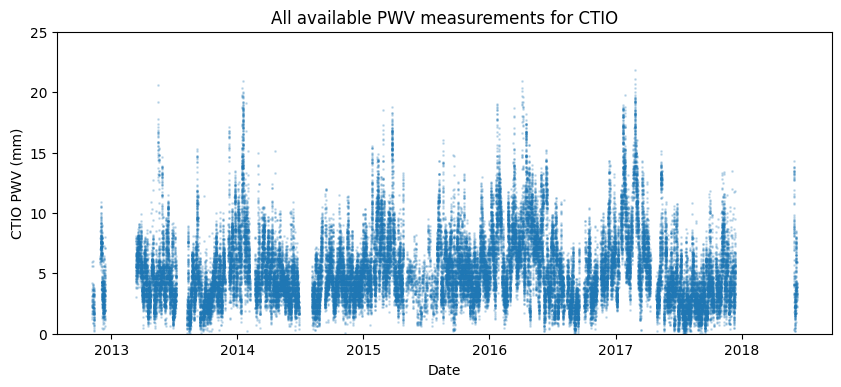

In [4]:
ctio_weather = ctio.weather_data()

ctio_weather.reset_index().plot.scatter('date', 'PWV', s=1, figsize=(10, 4), alpha=.2)
plt.ylabel('CTIO PWV (mm)')
plt.xlabel('Date')
plt.title('All available PWV measurements for CTIO')
plt.ylim(0, 25)


We don't have enough data to fully represent a 10 year long survey. Fortunately we are mostly interested in timescales of seasonal variability and shorter so we can consider data from a single year with good measurement coverage. The two years with the best coverage are 2016 and 2017.

Winter Average:  nan +\-  nan mm
Spring Average:  nan +\-  nan mm
Summer Average:  nan +\-  nan mm
Fall Average:   4.23 +\-  2.30 mm


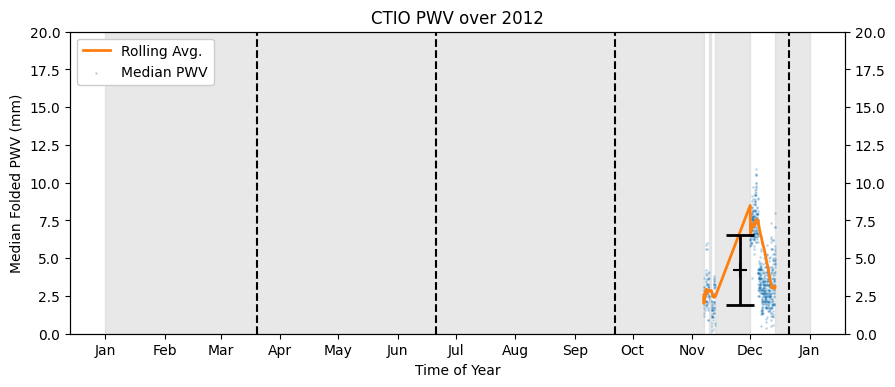

Winter Average:  6.45 +\-  2.28 mm
Spring Average:  4.85 +\-  2.27 mm
Summer Average:  3.95 +\-  2.34 mm
Fall Average:   4.32 +\-  2.16 mm


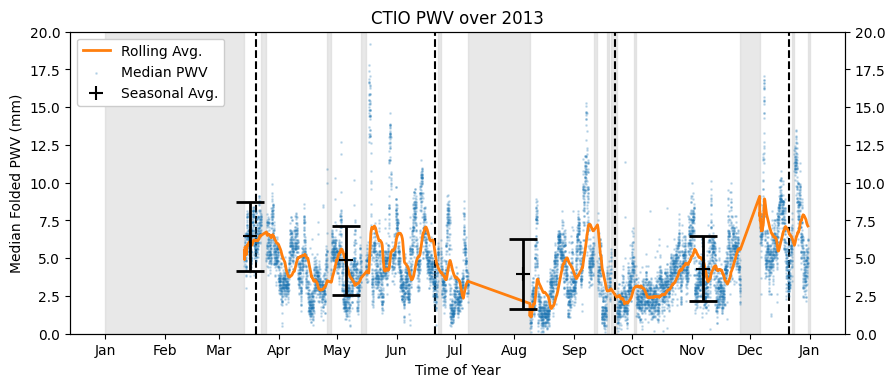

Winter Average:  6.59 +\-  3.29 mm
Spring Average:  4.49 +\-  1.71 mm
Summer Average:  4.04 +\-  1.85 mm
Fall Average:   4.54 +\-  1.69 mm


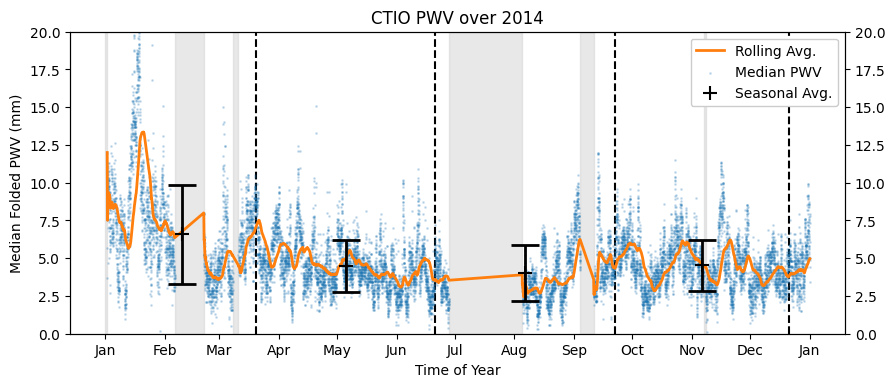

Winter Average:  6.46 +\-  2.59 mm
Spring Average:  5.62 +\-  3.14 mm
Summer Average:  5.44 +\-  2.41 mm
Fall Average:   5.17 +\-  1.95 mm


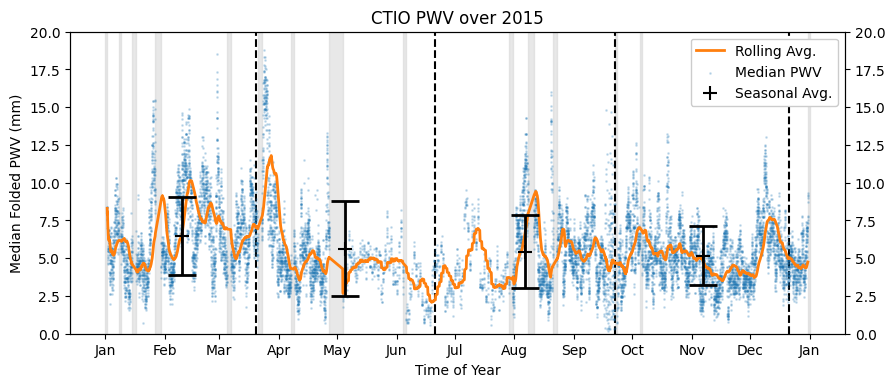

Winter Average:  7.13 +\-  2.90 mm
Spring Average:  7.44 +\-  3.18 mm
Summer Average:  3.93 +\-  2.12 mm
Fall Average:   4.95 +\-  2.18 mm


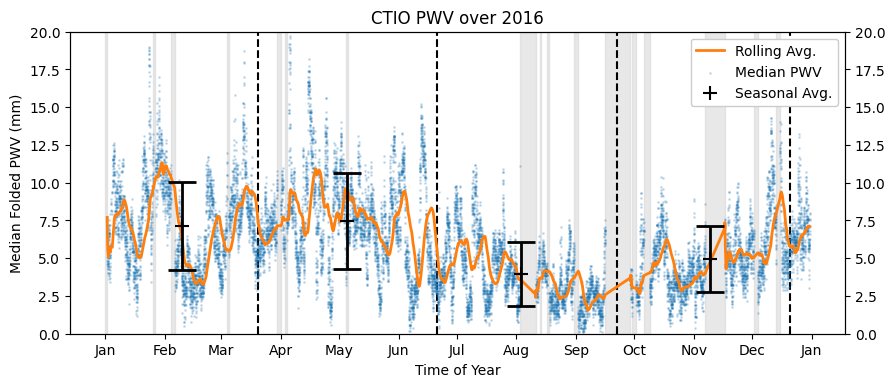

Winter Average:  8.75 +\-  3.93 mm
Spring Average:  5.07 +\-  2.56 mm
Summer Average:  3.12 +\-  1.79 mm
Fall Average:   4.46 +\-  2.10 mm


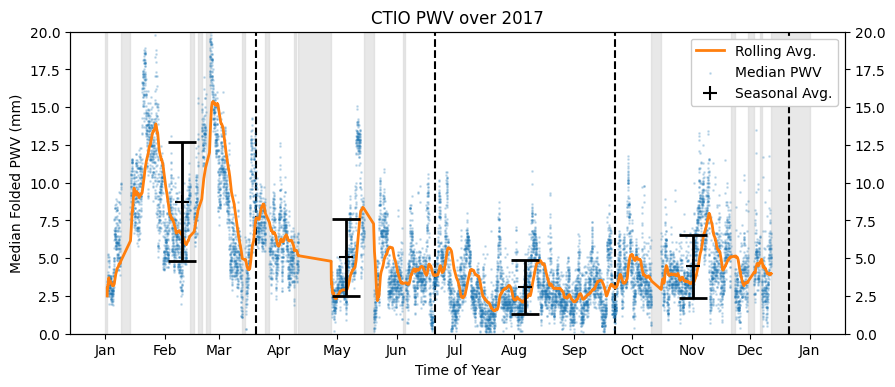

In [5]:
for year in range(2012, 2018):
    weather_for_year = ctio_weather[ctio_weather.index.year == year]
    plotting.plot_year_pwv_vs_time(weather_for_year.PWV)
    plt.title(f'CTIO PWV over {year}');
    plt.show()


Instead of thinking through some fancy statistics, we keep our approach simple and supplement missing data from 2016 with measurements taken in 2017.


Winter Average:  7.18 +\-  2.95 mm
Spring Average:  7.33 +\-  3.17 mm
Summer Average:  3.78 +\-  2.09 mm
Fall Average:   4.97 +\-  2.25 mm


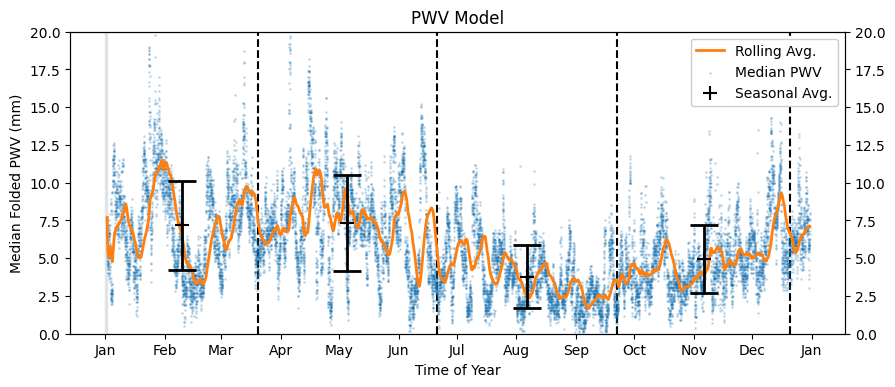

In [6]:
stacked_pwv = ctio_weather[np.isin(ctio_weather.index.year, (2016, 2017))].PWV
stacked_pwv = stacked_pwv.sort_index()

new_index = []
for date_idx in stacked_pwv.index:
    new_index.append(date_idx.replace(year=2016))
    
# Supplement missing data
stacked_pwv.index = new_index
stacked_pwv = stacked_pwv[~stacked_pwv.index.duplicated(keep='first')]

# Resample and interpolate any missing values
stacked_pwv = stacked_pwv.resample('30min', offset=timedelta(minutes=15)).interpolate()

plotting.plot_year_pwv_vs_time(stacked_pwv)
plt.title('PWV Model');


There may still a few periods of missing data in the above figure. Fortunately these periods are short so they can be interpolated over. To interpolate the PWV for a given datetime, we reindex our PWV model using the number of seconds that have elapsed in a given year. To avoid extrapolating at the boundaries, we extend our PWV model to slightly before / after the beginning / end of the year by wrapping the data across the boundaries.


In [7]:
def datetime_to_sec_in_year(dates):
    """Calculate number of seconds elapsed modulo 1 year
    
    Args:
        dates (pd.Datetime): Pandas datetime array
        
    Returns:
        A numpy array of integers
    """
    
    dates = pd.to_datetime(dates)
    
    hour_in_day = 24
    min_in_hour = sec_in_min = 60
    return (
        dates.dayofyear * hour_in_day * min_in_hour * sec_in_min
        + dates.hour * min_in_hour * sec_in_min
        + dates.minute * sec_in_min
    )


In [8]:
# Convert index values to seconds
pwv_model = stacked_pwv.copy()
pwv_model.index = datetime_to_sec_in_year(pwv_model.index)

# Resample the index to span the whole year
end_of_year = 365.25 * 24 * 60 * 60  # Days in year * hours * min * sec
delta = pwv_model.index[1] - pwv_model.index[0]
offset = pwv_model.index[1] % delta
new_indices = np.arange(-offset, end_of_year + offset + 2 * delta, delta)
pwv_model = pwv_model.reindex(new_indices) 

# Wrap values across the boundaries and fill nans with interpolation
first_not_nan, *_, last_not_nan = np.where(~pwv_model.isna())[0]
pwv_model.iloc[0] = pwv_model.iloc[last_not_nan]
pwv_model.iloc[-1] = pwv_model.iloc[first_not_nan]
pwv_model = pwv_model.interpolate()


(0.0, 25.0)

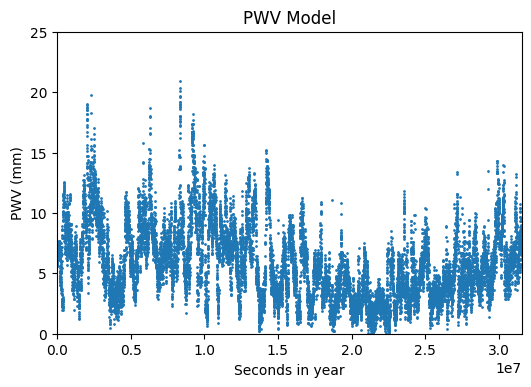

In [9]:
pwv_model.plot(marker='o', linestyle='', markersize=1)
plt.xlabel('Seconds in year')
plt.ylabel('PWV (mm)')
plt.title('PWV Model')
plt.xlim(pwv_model.index.min(), pwv_model.index.max())
plt.ylim(0, 25)


In [10]:
def build_interpolater_from_suomi_data(pwv_model):
    """Build interpolator for the PWV at a given point of the year
    
    Args:
        pwv_model (Series): PWV values indexed by seconds in year
        
    Returns:
        An interpolation function that accepts MJD
    """
    
    def interp(mjd):
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            x_as_datetime = Time(mjd, format='mjd').to_datetime()
            x_in_seconds = datetime_to_sec_in_year(x_as_datetime)
                
        return np.interp(
            x=x_in_seconds,
            xp=pwv_model.index,
            fp=pwv_model.values
        )
    
    return interp


In [11]:
pwv_interpolator = build_interpolater_from_suomi_data(pwv_model)


We make a quick validation plot to check the interpolation function.


In [12]:
def plot_interpolation_validation(pwv_data, pwv_interpolator):
    """Overplot the interpolated and measured PWV
    
    Args:
        df (DataFrame): Dataframe with PWV values and a Datetime index
        year   (float): Year of data to use from ``df``
    """
    
    pwv_data = pwv_data.sort_index()
    interpolated_pwv = pwv_interpolator(Time(pwv_data.index).mjd)

    plt.figure(figsize=(9, 3))
    plt.scatter(pwv_data.index, pwv_data.values, s=2, alpha=.1, label='Measured')
    plt.plot(pwv_data.index, interpolated_pwv, label='Interpolated', color='C1', alpha=.75)
    plt.ylabel('PWV (mm)')
    plt.xlabel('Date (UTC)')
    plt.legend()


(16801.0, 17532.0)

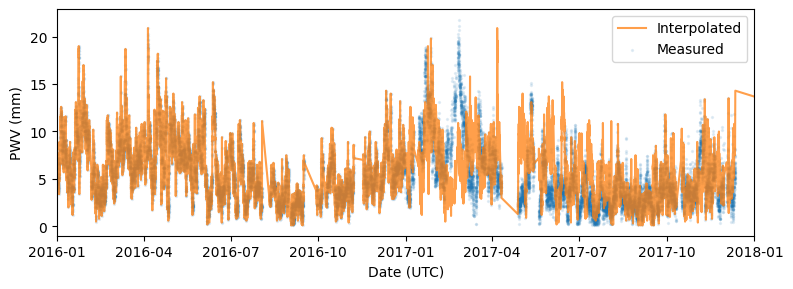

In [13]:
plot_interpolation_validation(ctio_weather.PWV, pwv_interpolator)
plt.xlim(datetime(2016, 1, 1), datetime(2018, 1, 1))


## The PLaSTICC Data

Instead of evaluating different cadences from scratch, we use light-curves from the PLaSTICC simulations. First we check what cadence simulations are available on the notebook's host server.


In [14]:
plasticc.get_available_cadences()


['alt_sched']

Simulated light-curves are written in the SNANA file format and are distributed across multiple files. We load a light-curve from one of these files and demonstrate the data model below. Each cadence includes simulations run with multiple supernova models. In this notebook we only need simulations for normal SNe (Model 11). 


In [15]:
demo_cadence = 'alt_sched'
demo_cadence_header_files = plasticc.get_model_headers(demo_cadence, 11)

print('Available cadence files:', len(demo_cadence_header_files))
print('Available Light-curves: ', plasticc.count_light_curves(demo_cadence, model=11))
    

Available cadence files: 1
Available Light-curves:  118071


In [16]:
demo_header_path = demo_cadence_header_files[0]
plasticc_lc = next(plasticc.iter_lc_for_header(demo_header_path, verbose=False))


In [17]:
plasticc_lc.meta


OrderedDict([('SUBSURVEY', '                                        '),
             ('SNID', '37008260        '),
             ('IAUC', 'NULL            '),
             ('FAKE', 2),
             ('RA', 279.406769),
             ('DECL', -57.209084),
             ('PIXSIZE', 0.20000000298023224),
             ('NXPIX', -9),
             ('NYPIX', -9),
             ('CCDNUM', 0),
             ('SNTYPE', 111),
             ('NOBS', 170),
             ('PTROBS_MIN', 1),
             ('PTROBS_MAX', 170),
             ('MWEBV', 0.08031467348337173),
             ('MWEBV_ERR', 0.004015733487904072),
             ('REDSHIFT_HELIO', 0.7880903482437134),
             ('REDSHIFT_HELIO_ERR', 0.04600000008940697),
             ('REDSHIFT_FINAL', 0.7878826260566711),
             ('REDSHIFT_FINAL_ERR', 0.04600000008940697),
             ('VPEC', 0.0),
             ('VPEC_ERR', 300.0),
             ('HOSTGAL_OBJID', 439729),
             ('HOSTGAL_PHOTOZ', 0.7880903482437134),
             ('HOSTGA

In [18]:
plasticc_lc


MJD,FLT,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,SKY_SIG,ZEROPT,SIM_MAGOBS
float64,str2,str12,int32,float32,float32,float32,float32,float32,float32,float32
61878.423,r,NULL,0,0.0,2.5760086,6.540902,1.54,43.34,31.6,98.81546
61880.4065,z,NULL,0,0.0,-3.9193785,10.498238,1.49,42.78,30.95,26.558031
61880.4184,Y,NULL,0,0.0,10.406313,28.914253,1.38,55.41,30.03,26.103807
61883.3882,i,NULL,0,0.0,9.771535,8.078404,1.98,30.92,31.23,25.168234
61883.3995,u,NULL,0,0.0,-10.195051,12.091671,2.02,2.67,28.38,25.942005
61885.383,g,NULL,0,0.0,-0.52016217,4.3740625,2.47,13.58,31.38,26.537094
61885.394,r,NULL,0,0.0,5.3698688,5.6030397,2.24,22.6,31.47,25.356913
61891.3905,r,NULL,4096,0.0,25.516718,4.3598304,1.72,22.64,31.48,24.228033
61891.4024,i,NULL,4096,0.0,29.026356,6.261057,1.53,30.93,31.24,23.79404


Here we reformat the data to be compatible with `sncosmo` so we can easily visualize the light-curve.


In [19]:
formatted_lc = plasticc.format_plasticc_sncosmo(plasticc_lc)


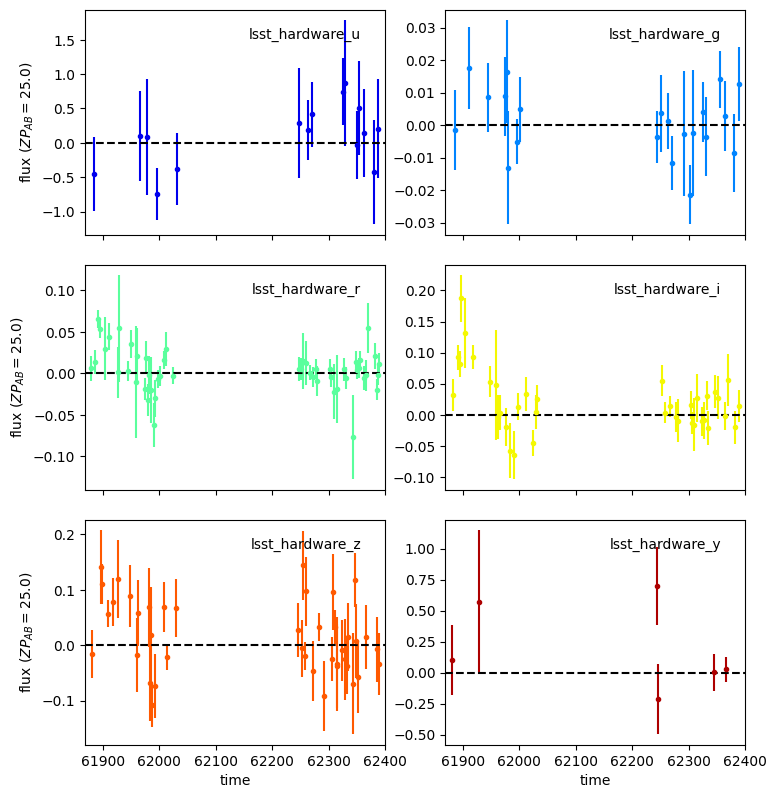

In [20]:
sncosmo.plot_lc(formatted_lc);


## Simulating Light-Curves

Since we need to add in our own atmospheric variability, the pre-tabulated flux values above are of limited use. Instead, we use the PLaSTICC light-curves to establish the cadence and model parameters for each simulated SN. This information is then used to simulate our own light-curves with `sncosmo`.


**Note:** See Issue 8 (https://github.com/LSSTDESC/SN-PWV/issues/8) for caveats about the following cell.

In [21]:
model_for_sim = sncosmo.Model('salt2-extended')
duplicated_lc = plasticc.duplicate_plasticc_sncosmo(plasticc_lc, model_for_sim, gain=20, skynr=100)


In [22]:
duplicated_lc.meta


{'t0': 61902.7578125,
 'x1': -1.8033403158187866,
 'c': -0.09971537441015244,
 'z': 0.7520696520805359,
 'x0': 3.037939767619893e-06}

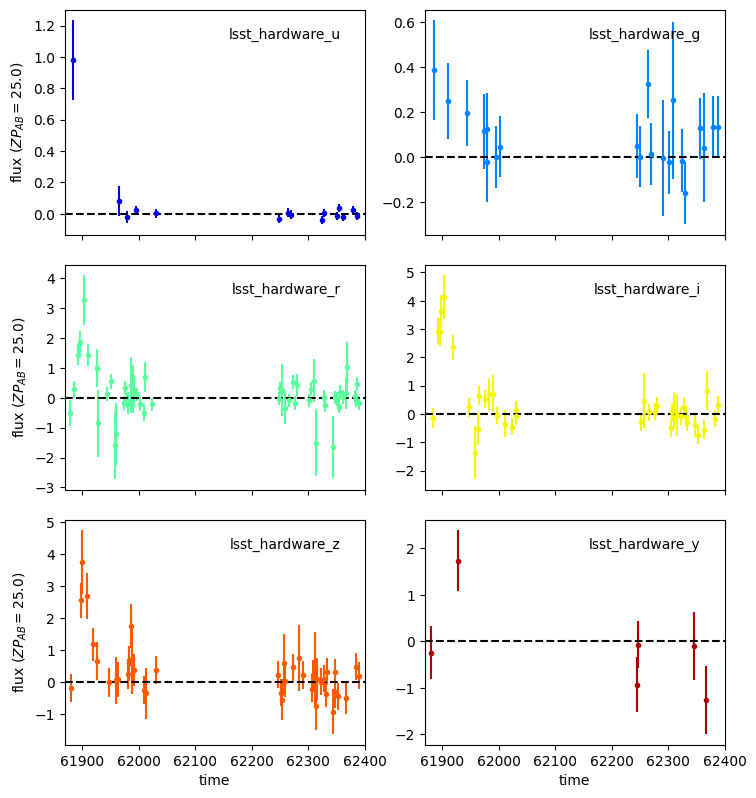

In [23]:
sncosmo.plot_lc(duplicated_lc);


In [24]:
duplicated_lc


time,band,flux,fluxerr,zp,zpsys
float64,str15,float64,float64,int64,str2
61878.423,lsst_hardware_r,-0.5152864682428278,0.43681073464585235,25,ab
61880.4065,lsst_hardware_z,-0.20117525077097922,0.43802877956800107,25,ab
61880.4184,lsst_hardware_y,-0.24514763965138242,0.5661565989188762,25,ab
61883.3882,lsst_hardware_i,-0.1329375217805736,0.3578810184732754,25,ab
61883.3995,lsst_hardware_u,0.9820331683824904,0.25463165928016457,25,ab
61885.383,lsst_hardware_g,0.3887968653402638,0.22170036958850728,25,ab
61885.394,lsst_hardware_r,0.2869335511498465,0.27981877000602196,25,ab
61891.3905,lsst_hardware_r,1.444315075675274,0.35889028594466843,25,ab
61891.4024,lsst_hardware_i,2.920684292066413,0.46041635414371174,25,ab


The `sncosmo` package doesn't have a clearly defined approach to adding time variable propagation effects, so we use our own custom modeling class. The `PWVVariableModel` class is a child of the `sncosmo.Model` class and overloads the underlying flux calculation by adding PWV transmission effects. Note that in this approach the `t0` parameter for each light-curve is now in units of MJD (i.e., it must be the same units as the interpolation function).


In [25]:
def plot_variable_pwv_model(model_with_pwv, phase=0, params=dict()):
    """Overplot a sncosmo model with and without temporally variable PWV
    
    Args:
        source (str, Source): sncosmo source to plot
        phase        (float): Phase of the supernova to plot
        params        (dict): Non-PWV related parameters for the model
    """
    
    wave = np.arange(3000, 12000)
    time = phase + params['t0']

    model_without_pwv = sncosmo.Model(model_with_pwv.source)
    model_without_pwv.update(params)
    flux_without_pwv = model_without_pwv.flux(time, wave)

    model_with_pwv.update(params)
    flux_with_pwv = model_with_pwv.flux(time, wave)

    fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    ax.plot(wave, flux_without_pwv, label='Base Model', color='C1')
    ax.plot(wave, flux_with_pwv, label='Model with PWV', color='C0')
    ax.set_title('Simulated Flux')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_xlabel('Wavelength (A)')
    ax.set_xlim(min(wave), max(wave))

    plt.tight_layout()


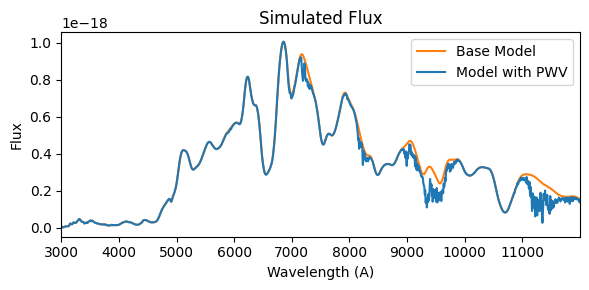

In [26]:
pwv_effect_no_airmass = modeling.VariablePWVTrans(pwv_interpolator, scale_airmass=False)
pwv_effect_no_airmass.set(res=5)

demo_model = modeling.Model(
    source='salt2-extended',
    effects=[pwv_effect_no_airmass],
    effect_names=[''],
    effect_frames=['obs']
)

plot_variable_pwv_model(
    demo_model,     
    params = {
        'z': 0.752069652,
        't0': 61900,
        'x0': 3e-06,
        'x1': -1.8,
        'c': -0.1}
)


## Airmass Scaling


In [27]:
def plot_airmass_validation(cadence, model=11, mjd=0):
    ra = []
    dec = []
    peak = []

    for header_path in plasticc.get_model_headers(cadence, 11):
        header_data = fits.open(header_path)[1].data
        ra.extend(header_data['RA'])
        dec.extend(header_data['DECL'])
        if mjd == 'peak':
            peak.extend(header_data['PEAKMJD'])

    if mjd == 'peak':
        mjd = peak
    
    airmass = modeling.calc_airmass(
        time=mjd,
        ra=ra,
        dec=dec,
        lat=constants.vro_latitude.value,
        lon=constants.vro_longitude.value,
        alt=constants.vro_longitude.value
    )

    
    is_positive_airmass = np.array(airmass) >= 0 
    positive_airmass = airmass[is_positive_airmass]
    
    lsst_coord = SkyCoord(constants.vro_latitude, constants.vro_longitude).galactic
    sn_coord = SkyCoord(ra, dec, unit=u.deg).galactic
    positive_coords = sn_coord[is_positive_airmass]
    negative_coords = sn_coord[~is_positive_airmass]
    
    plt.figure(figsize=(10, 5))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)
    
    scat = plt.scatter(positive_coords.l.wrap_at('180d').radian, positive_coords.b.radian, c=positive_airmass, vmin=1, vmax=8, s=10)
    plt.scatter(negative_coords.l.wrap_at('180d').radian, negative_coords.b.radian, c='lightgrey', label='Over Horizon')
    plt.scatter(lsst_coord.l.wrap_at('180d').radian, lsst_coord.b.radian,color='C1', marker='*', s=100, label='VRO')
    plt.legend(framealpha=1)
    plt.colorbar(scat).set_label('Airmass', rotation=270, labelpad=15)
    

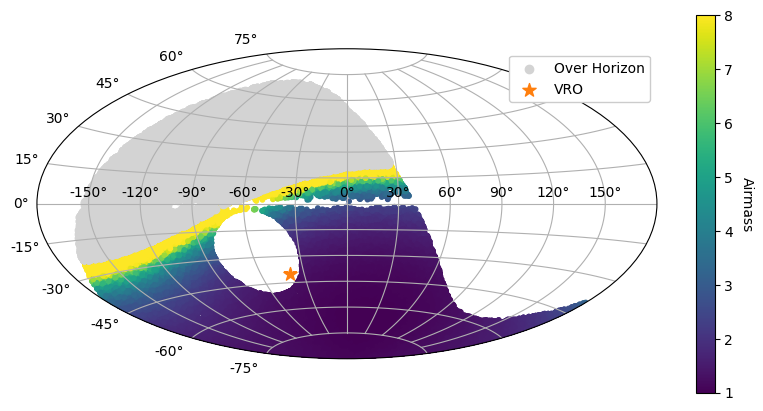

In [28]:
plot_airmass_validation(demo_cadence)


## Fitting Light-Curves

We create an iterator that extracts cadence data from PLaSTICC light-curves and simulates custom light-curves with time variable PWV effects. We then fit each light-curve and look at the aggregate properties. In order to ensure a successful fit for each light-curve, we apply the following quality cuts:

1. Light-curves must have at least one point with SNR >= 5 in two or more bands
2. So that the simulated data is within the wavelength range of the model, light-curves with a redshift greater than .8 are dropped. 

In [29]:
def iter_custom_lcs(
        model, cadence, iter_lim=None, gain=20, skynr=100, quality_callback=None, verbose=True):
    """Simulate light-curves for a given PLaSTICC cadence
    
    Args:
        model               (Model): Model to use in the simulations
        cadence               (str): Cadence to use when simulating light-curves
        gain                  (int): Gain to use during simulation
        skynr                 (int): Simulate skynoise by scaling plasticc ``SKY_SIG`` by 1 / skynr
        quality_callback (callable): Skip light-curves if this function returns False
        verbose              (bool): Display a progress bar
    """
    
    # model = copy(model)
    
    # Determine redshift limit of the given model
    u_band_low = sncosmo.get_bandpass('lsst_hardware_u').minwave()
    source_low = model.source.minwave()
    zlim = (u_band_low / source_low) - 1
    
    counter = -1
    iter_lim = float('inf') if iter_lim is None else iter_lim
    for light_curve in plasticc.iter_lc_for_cadence_model(cadence, model=11, verbose=verbose):
        counter += 1
        if counter >= iter_lim:
            break
        
        if light_curve.meta['SIM_REDSHIFT_CMB'] >= zlim:
            continue
        
        model.set(ra=light_curve.meta['RA'], dec=light_curve.meta['DECL'])
        duplicated_lc = plasticc.duplicate_plasticc_sncosmo(light_curve, model, gain=gain, skynr=skynr)
        
        # sncosmo.plot_lc(duplicated_lc)
        # plt.show()

        if quality_callback and not quality_callback(duplicated_lc):
            continue
            

        yield duplicated_lc 
        

In [30]:
def passes_quality_cuts(light_curve):
    """Return whether light-curve has 2+ two bands each with 1+ data point with SNR > 5
    
    Args:
        light_curve (Table): Astropy table with sncosmo formatted light-curve data
        
    Returns:
        A boolean
    """
    
    if light_curve.meta['z'] > .88:
        return False
    
    light_curve = light_curve.group_by('band')
    
    passed_cuts = []
    for band_lc in light_curve.groups:
        passed_cuts.append((band_lc['flux'] /  band_lc['fluxerr'] > 5).any())
        
    return sum(passed_cuts) >= 2
        

We pause to visually check a light-curves from our iterator. As a simple validation, we simulate light-curves with and without PWV.

In [31]:
variable_pwv_effect = modeling.VariablePWVTrans(pwv_interpolator)
variable_pwv_effect.set(res=5)

sn_model_with_pwv = modeling.Model(
    source='salt2-extended',
    effects=[variable_pwv_effect],
    effect_names=[''],
    effect_frames=['obs']
)


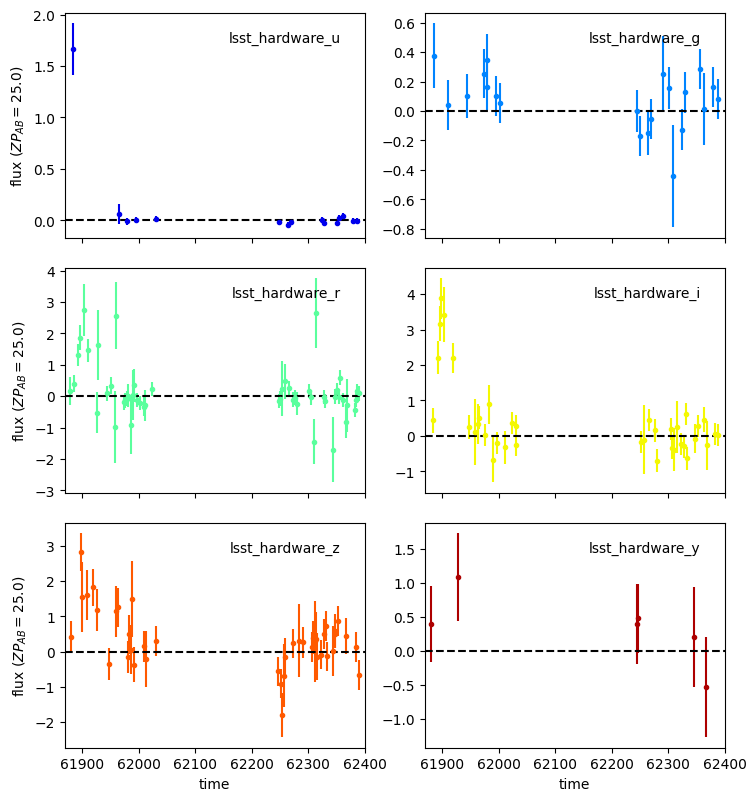

In [32]:
l = next(iter_custom_lcs(sn_model_with_pwv, demo_cadence, verbose=False))
sncosmo.plot_lc(l);


In [33]:
light_curves = iter_custom_lcs(sn_model_with_pwv, demo_cadence, iter_lim=5, quality_callback=passes_quality_cuts)

model_without_pwv = sncosmo.Model('salt2-extended')
fitted_mag, fitted_params = sn_magnitudes.fit_mag(
    model=model_without_pwv, 
    light_curves=light_curves, 
    vparams=['x0', 'x1', 'c'], 
    bands=['lsst_hardware_' + b for b in 'ugrizy'])


  0%|          | 0/118071 [00:00<?, ?it/s]/home/djperrefort/anaconda3/envs/sn-pwv/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)

  0%|          | 1/118071 [00:11<373:01:33, 11.37s/it]/home/djperrefort/anaconda3/envs/sn-pwv/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)

  0%|          | 3/118071 [00:27<325:28:12,  9.92s/it]/home/djperrefort/anaconda3/envs/sn-pwv/lib/python3.8/site-packages/sncosmo/models.py:188: RuntimeWarning: divide by zero encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)

alt_sched:   0%|          | 0/1 [01:02<?, ?it/s]
